In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

from tensorflow.keras import backend as K
K.clear_session()

In [14]:
from joblib import load, dump
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
from skimage.filters import gaussian

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, accuracy_score

from src.data_preprocessing import load_and_prep_image
from src.use_model import make_prediction, LABEL_NAMES, MODEL
from src.training_evaluation import IMG_SIZE

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
pd.set_option("display.max_rows", 101)
pd.set_option('display.float_format', '{:.2f}'.format)

# Results analysis

In [6]:
test_data, _ = image_dataset_from_directory("food101_test",
                                             validation_split=0.2,
                                             image_size=(IMG_SIZE, IMG_SIZE),
                                             seed=42,
                                             subset="both"
                                            )

In [44]:
test_data = test_data.rebatch(1)

results = {
    "labels": [],
    "predictions": [],
    "probs": []
}
wrong_preds = {
    "image": [],
    "label": [],
    "pred": [],
    "probs": []
}

for image, label in test_data:
    label = int(label.numpy()[0])
    prob = MODEL.predict(image, verbose=0)
    pred = int(tf.argmax(prob, axis=1).numpy()[0])
    
    results["labels"].append(label)
    results["predictions"].append(pred)
    results["probs"].append(prob)

    if label != pred:
        wrong_preds["image"].append(image)
        wrong_preds["label"].append(label)
        wrong_preds["pred"].append(pred)
        wrong_preds["probs"].append(prob)

dump(results, "results/results_with_probs.pkl")
dump(wrong_preds, "results/wrong_preds_with_probs.pkl")

print(f"Test accuracy: {np.round(accuracy_score(results["labels"], results["predictions"]), 3)}")

Test accuracy: 0.835


## Results sorted by f1-score descending

In [6]:
df = (pd.DataFrame(classification_report(results["labels"],
                                         results["predictions"],
                                         output_dict=True))
      .T.iloc[:-3, :]
      .rename({"support": "n_samples"}, axis=1)
     )
df["label_name"] = LABEL_NAMES
df["n_samples"] = df["n_samples"].astype(int)
(df
 .sort_values(by="f1-score", ascending=False)
 .style.background_gradient(subset=["f1-score"])
 .format(subset=df.columns[:-2], formatter="{:.2f}"))

# Wrong predictions

In [100]:
wrong_pred_labels = np.array(wrong_preds["label"])
wrong_pred_preds = np.array(wrong_preds["pred"])
analysis = {}
for idx in df.loc[df["f1-score"] < 0.75].index.values:
    idx = int(idx)
    idxs = np.where(idx == wrong_pred_labels)[0]
    class_wrong_preds = Counter(wrong_pred_preds[idxs])
    analysis[LABEL_NAMES[idx]] = [f"{LABEL_NAMES[key]} ({f"{value / len(idxs):.0%}"})" 
                                  for key, value in class_wrong_preds.most_common(3)]
analysis = pd.DataFrame(analysis).T.set_axis(["1st", "2nd", "3rd"], axis=1)
analysis.columns = pd.MultiIndex.from_tuples([("Most common mistakes for worst predicted classes (F1 score < 0.75)", col)
                                              for col in analysis.columns])
analysis

Most common mistakes for worst predicted classes (F1 score < 0.75)  \
                                                                                1st   
apple_pie                                       bread_pudding (29%)                   
ceviche                                          tuna_tartare (16%)                   
cheesecake                               strawberry_shortcake (21%)                   
chocolate_mousse                               chocolate_cake (44%)                   
crab_cakes                                           scallops (25%)                   
filet_mignon                                            steak (55%)                   
foie_gras                                        cheese_plate (10%)                   
gnocchi                                              scallops (13%)                   
beet_salad                                      caprese_salad (20%)                   
huevos_rancheros                            breakfast_burrito (12%)                   
pork_chop                                               steak (30%)                   
bread_pudding                                       apple_pie (19%)                   
ravioli                                               gnocchi (25%)                   
risotto                                            fried_rice (18%)                   
steak                                            filet_mignon (37%)                   
tuna_tartare                                     beef_tartare (25%)                   

                                                                  
                                     2nd                     3rd  
apple_pie                   baklava (8%)           beignets (6%)  
ceviche           shrimp_and_grits (10%)                pho (8%)  
cheesecake             panna_cotta (12%)       carrot_cake (12%)  
chocolate_mousse       panna_cotta (11%)          ice_cream (7%)  
crab_cakes                takoyaki (11%)          pork_chop (9%)  
filet_mignon             pork_chop (15%)          prime_rib (8%)  
foie_gras               beet_salad (10%)       filet_mignon (8%)  
gnocchi           shrimp_and_grits (13%)           ceviche (11%)  
beet_salad             beef_tartare (7%)       tuna_tartare (7%)  
huevos_rancheros             tacos (10%)            ravioli (9%)  
pork_chop             filet_mignon (19%)    grilled_salmon (12%)  
bread_pudding         french_toast (11%)   chocolate_mousse (6%)  
ravioli                    scallops (8%)     beef_carpaccio (8%)  
risotto                    gnocchi (16%)  shrimp_and_grits (14%)  
steak                    pork_chop (18%)         prime_rib (14%)  
tuna_tartare            beet_salad (20%)         foie_gras (12%)

It's not surprising that most prediction errors occur, as the mistaken dishes can look very similar. It also turned out that errors appear in the test data as well, even though, according to the dataset description, they were supposed to occur only in the training data.

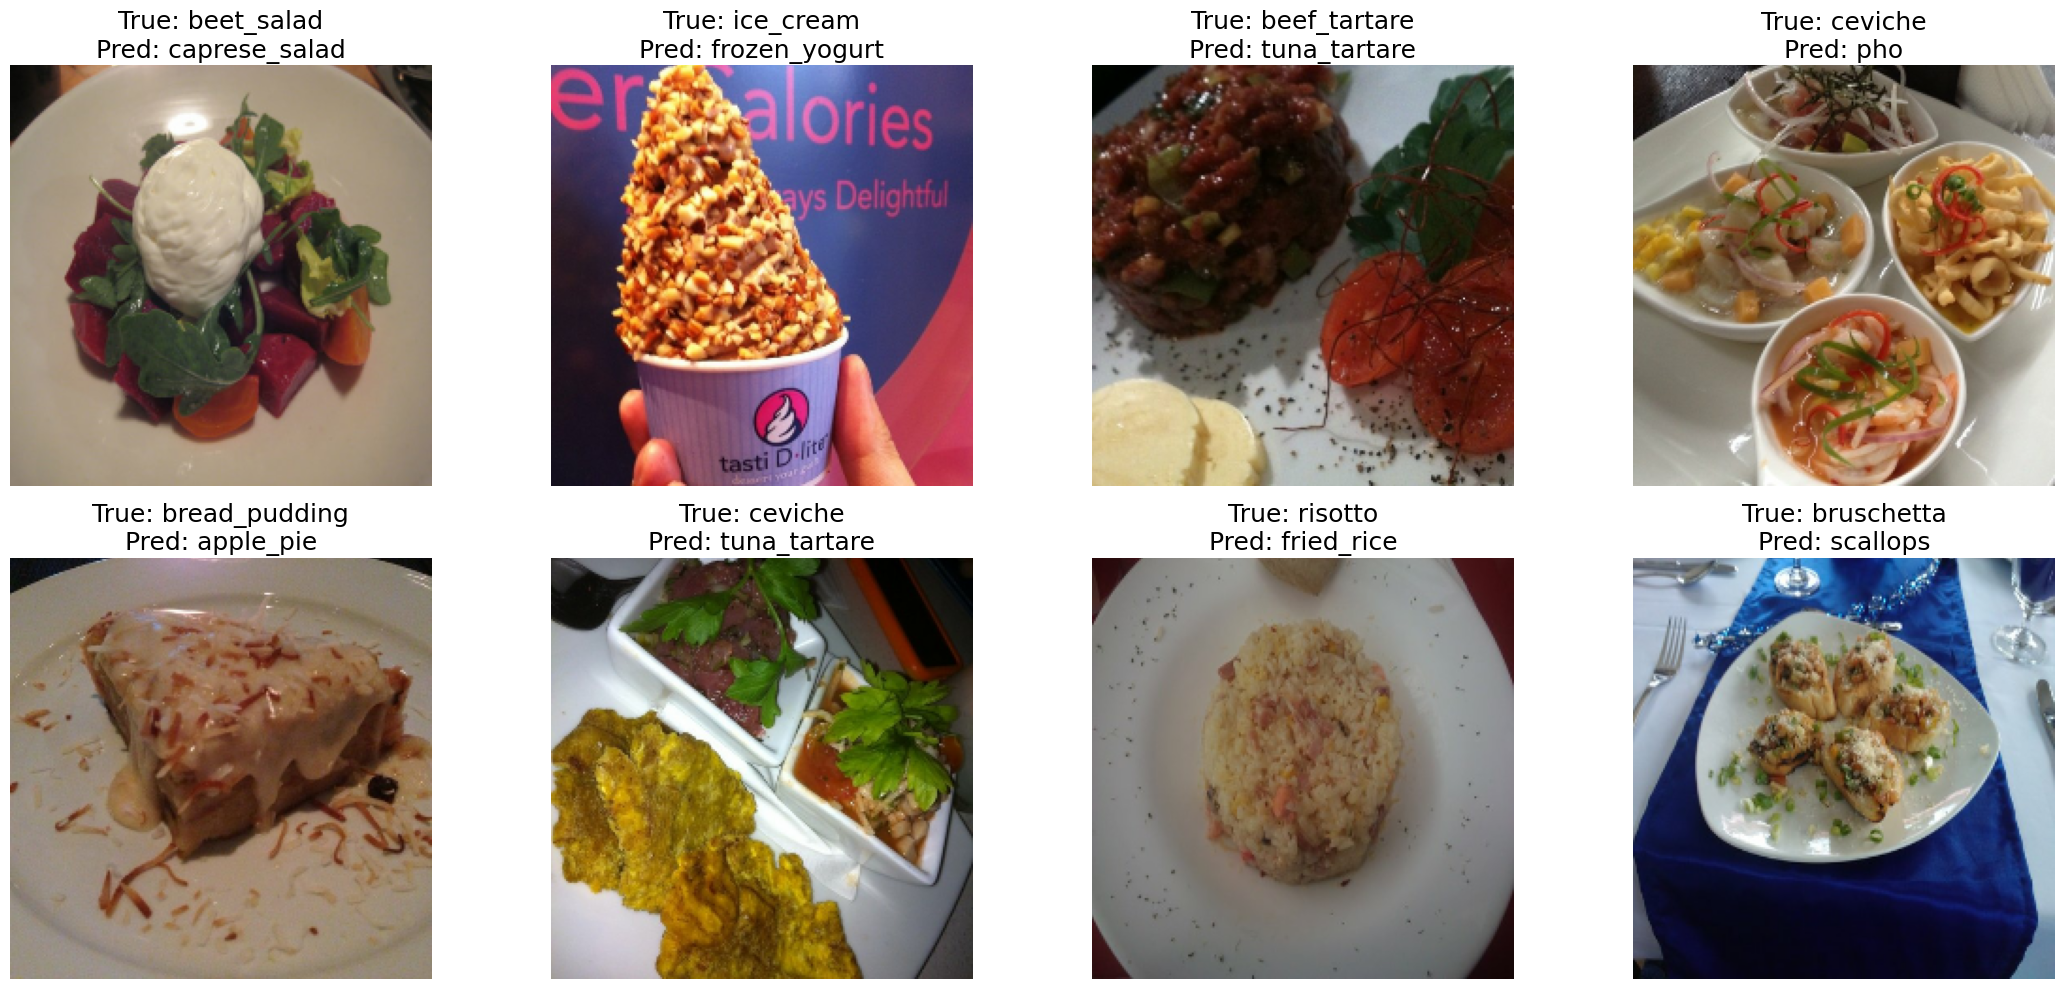

In [232]:
idxs = np.random.choice(range(len(wrong_pred_preds)), 8)

fig, ax = plt.subplots(2, 4, figsize=(22, 10))
ax = ax.flatten()
for i, (image, label, pred) in enumerate(zip(np.array(wrong_preds["image"])[idxs],
                                             wrong_pred_labels[idxs],
                                             wrong_pred_preds[idxs]
                                            )):
    ax[i].imshow(image)
    ax[i].axis("off")
    ax[i].set_title(f"True: {LABEL_NAMES[label]}\nPred: {LABEL_NAMES[pred]}", fontsize=18)
plt.tight_layout()
plt.show()

# How the model makes decisions

We can see what features most affect the model's prediction thanks to the XAI method - Lime. This is super interesting, however, in this case it seems not necessary - after previous analysis and reviewed many examples of mistakes (only a few are presented above), we understand what most of the model's errors are due to. \
The less important part of the images has been moderately blurred with a Gaussian filter, because we still want to see what's there, and Lime provides us with the option to hide that part completely.

In [41]:
explainer = LimeImageExplainer()

def explain_image(image, explainer=explainer, model=MODEL, scale=True):
    
    if isinstance(image, str):
        image = load_and_prep_image(image)
    elif isinstance(image, tf.Tensor):
        pass

    explanation = explainer.explain_instance(
        tf.squeeze(image).numpy(), 
        classifier_fn=model.predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000,
        random_seed=42
    )
    label = np.argmax(model.predict(image, verbose=False))
    temp, mask = explanation.get_image_and_mask(
        label,
        positive_only=True,
        num_features=20,
        hide_rest=False
    )
    
    blurred_image = gaussian(temp, sigma=1.8)
    temp[mask == 0] = blurred_image[mask == 0]
    final_image = mark_boundaries(temp/255., mask, color=(0, 0, 0))

    return final_image, label

def show_explanations(explanations, trues, preds, suptitle=None):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for i, (img, true, pred) in enumerate(zip(explanations, trues, preds)):
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f"True: {true}\nPred:{LABEL_NAMES[pred]}", fontsize=18)
    plt.tight_layout()
    plt.show()

## Our images

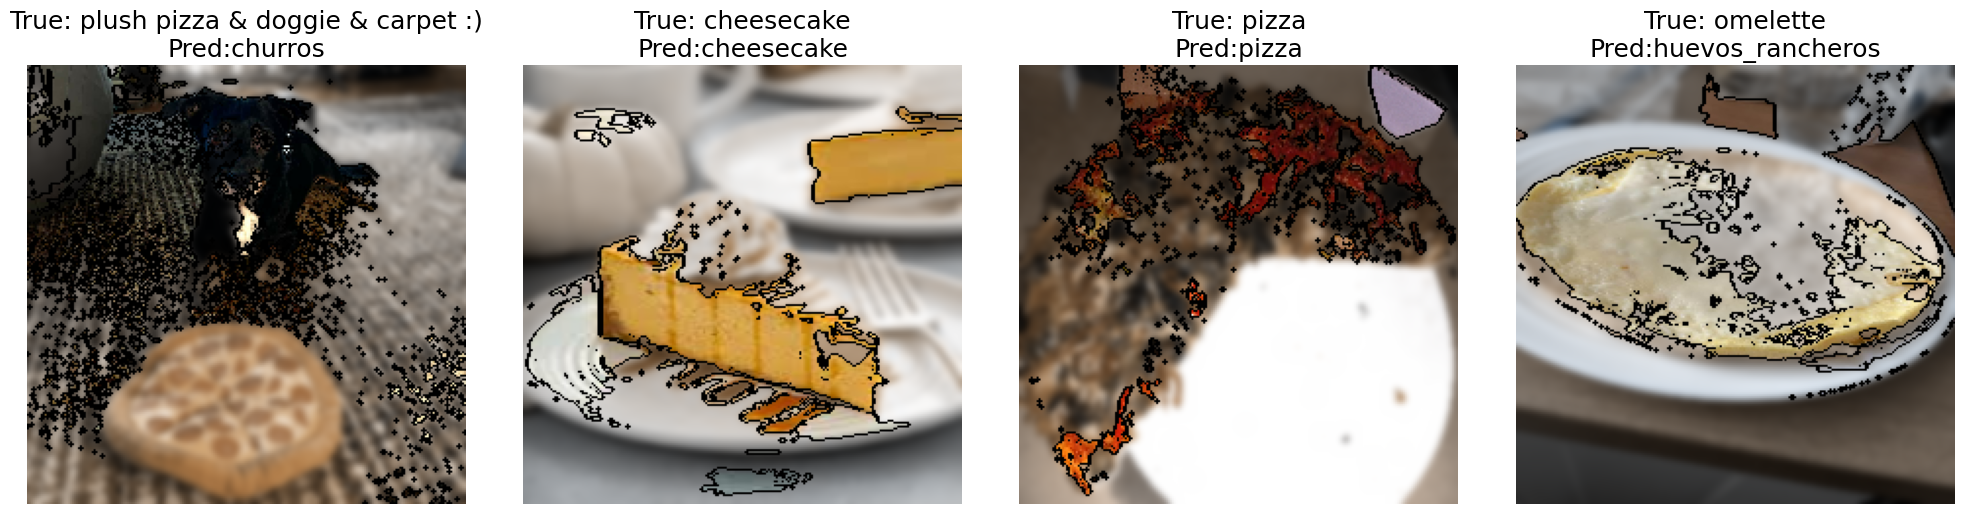

In [49]:
my_photos = ["images/pizza_lola.jpeg", "images/test/cheesecake.jpg",
             "images/test/pizza.jpg", "images/test/omlet.jpeg"]
true_labels = ["plush pizza & doggie & carpet :)", "cheesecake", "pizza", "omelette"]
explained_images = []
pred_labels = []

for path in my_photos:
    image, label = explain_image(path)
    explained_images.append(image)
    pred_labels.append(label)

show_explanations(explained_images, true_labels, pred_labels)

## Wrong predictions from test dataset

In [28]:
wrong_preds = load("results/wrong_preds_with_probs.pkl")

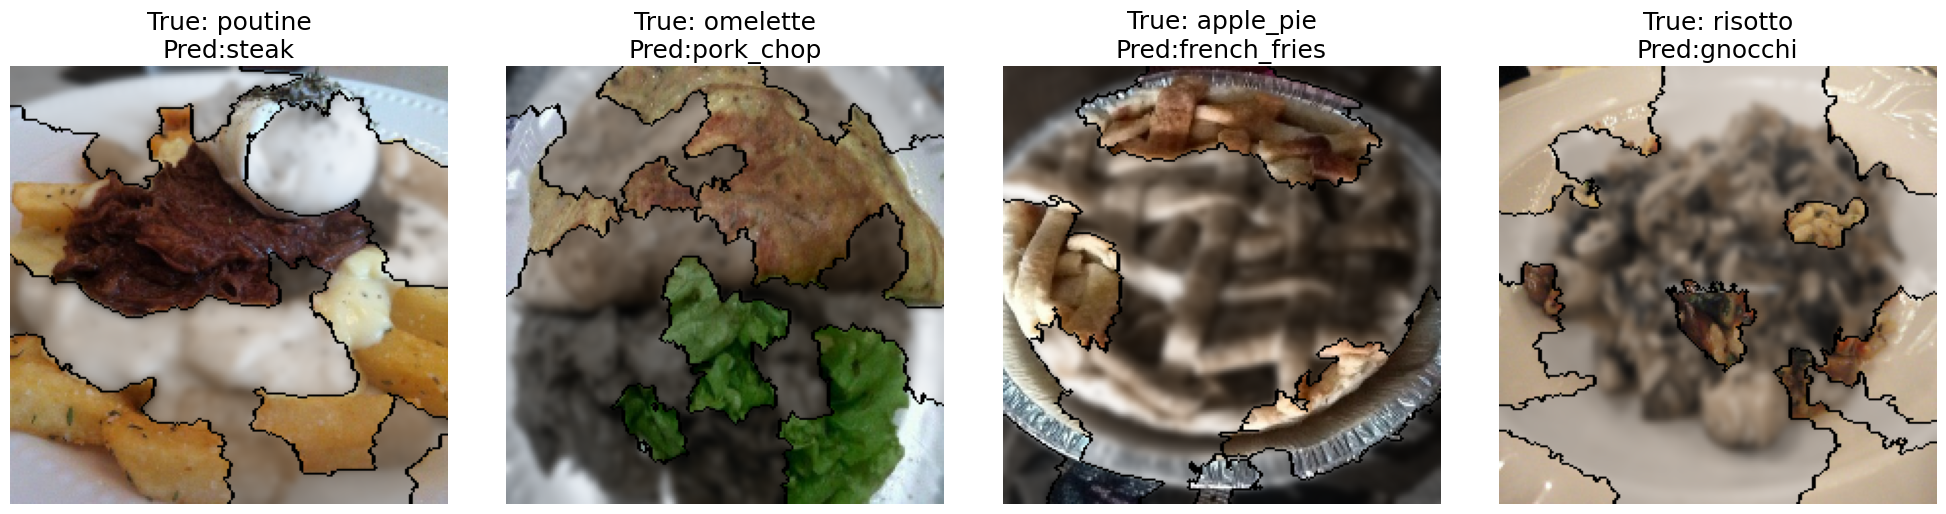

In [57]:
idxs = np.random.choice(range(len(wrong_preds["image"])), 4, replace=False)

explained_images = []
trues = [LABEL_NAMES[i] for i in np.array(wrong_preds["label"])[idxs]]
for img in np.array(wrong_preds["image"])[idxs]:
    image, _ = explain_image(img)
    explained_images.append(image)

show_explanations(explained_images,
                  trues,
                  np.array(wrong_preds["pred"])[idxs])

After reviewing quite a number of such examples, however, we may want to look at the predictions in more detail, for example, we see a bit too much plate in our explanations. Also, with Lime, only features indicating 1 top class were analyzed, and 1000 samples were generated for explenations, which is beneficial in terms of time, but may not be enough for accurate analysis. The meaningful number of features to be shown can also depend on the image, so we will try to take a closer look at selected images.

In addition, we still want to find out how confident the model is in its decision.